Bot_6

# Chargement des données

In [1]:
import pandas as pd

from IPython.display import display
from urllib.parse import quote

doc2start = {"bpt6k63243601": 123, "bpt6k62931221": 151, "bpt6k6286466w": 189, "bpt6k6393838j": 219, "bpt6k6331310g": 216, "bpt6k6292987t": 353, "bpt6k62906378": 288, "bpt6k6391515w": 319, "bpt6k6315927h": 349, "bpt6k6319106t": 324, "bpt6k6315985z": 82, "bpt6k63959929": 82, "bpt6k63197984": 56, "bpt6k6389871r": 77, "bpt6k6319811j": 79, "bpt6k6282019m": 72, "bpt6k6314752k": 190, "bpt6k6305463c": 113, "bpt6k6318531z": 108, "bpt6k6324389h": 72, "bpt6k63243920": 80, "bpt6k6309075f": 96, "bpt6k6333200c": 132, "bpt6k63243905": 134, "bpt6k6333170p": 137, "bpt6k96727875": 135, "bpt6k9764746t": 99, "bpt6k97645375": 123, "bpt6k9672117f": 125, "bpt6k9763554c": 123, "bpt6k9763553z": 105, "bpt6k9677392n": 110, "bpt6k9692809v": 113, "bpt6k9762929c": 129, "bpt6k9672776c": 119, "bpt6k9764647w": 121, "bpt6k9669143t": 145, "bpt6k9677737t": 139, "bpt6k9668037f": 167, "bpt6k96839542": 171, "bpt6k96762564": 185, "bpt6k9685861g": 189, "bpt6k9763471j": 153, "bpt6k9762899p": 157, "bpt6k97630871": 11, "bpt6k9684454n": 235, "bpt6k9732740w": 239, "bpt6k9684013b": 189, "bpt6k9692626p": 305, "bpt6k9685098r": 281, "bpt6k9764402m": 329, "bpt6k97631451": 322, "bpt6k9776121t": 49, "bpt6k9775724t": 33, "bpt6k97774838": 327, "bpt6k9780089g": 339}

def entry2url(row):
    """
    Takes a row of an Annuaire csv and
    transforms it to the corresponding Gallica url
    """
    url = "https://gallica.bnf.fr/ark:/12148/"
    
    directory = row['directory']
    page = row['page'] - doc2start[directory]
    url += f"{row['directory']}/f{row['page']-doc2start[row['directory']]}"
    
    r_strings = []
    if 'name' in row and pd.notna(row['name']):
        r_strings.append(quote(row['name'].replace('.', ' ')))
    if 'job' in row and pd.notna(row['job']):
        r_strings.append(quote(row['job'].replace('.', ' ')))
    if 'street' in row and pd.notna(row['street']):
        r_strings.append(quote(row['street'].replace('.', ' ')))
    if 'number' in row and pd.notna(row['number']):
        r_strings.append(quote(row['number'].replace('.', ' ')))
    
    if len(r_strings) > 0:
        url += f".item.r={'%20'.join(r_strings)}.zoom"
    
    return url

def add_clickable_url(bottin_dataframe):
    bottin_dataframe = bottin_dataframe.copy()
    bottin_dataframe['url'] = bottin_dataframe.apply(entry2url, axis=1)
    #def make_clickable(val):
    #    return '<a href="{}">gallica url</a>'.format(val,val)

    #return bottin_dataframe.style.format(make_clickable, subset=['url'])
    return bottin_dataframe

In [2]:
data_bottin = pd.read_csv('bottin_data_groupe_6.csv')

# Aperçu des données

In [3]:
# Infos de base

entries_number = data_bottin.shape[0] 
entries_per_year = data_bottin.groupby('year').size() 
unique_names_number = data_bottin['name'].unique().size 
unique_jobs_number = data_bottin['job'].unique().size 
unique_streets_number = data_bottin['street'].unique().size 

print(f"Il y {entries_number} entrées, dont {unique_names_number} noms uniques, {unique_jobs_number} métiers uniques, {unique_streets_number} rue uniques")
print("\nLa distribution d'entrées par année est la suivante:")
print("\n".join([f"\t{year}: {count}" for year, count in entries_per_year.reset_index().values]))

Il y 869824 entrées, dont 228108 noms uniques, 63795 métiers uniques, 41640 rue uniques

La distribution d'entrées par année est la suivante:
	1888: 101782
	1890: 98413
	1893: 101588
	1894: 104941
	1896: 111475
	1897: 113710
	1898: 117566
	1900: 120349


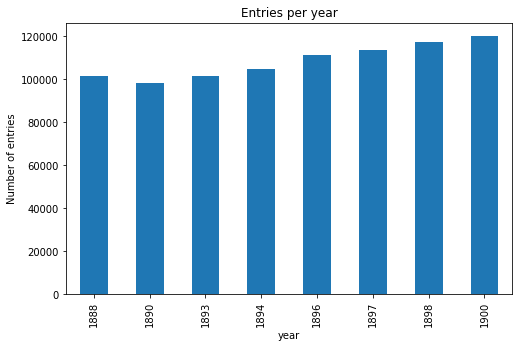

In [4]:
# histogramme par années

(data_bottin.groupby('year').size()
 .plot(kind='bar', title='Entries per year', figsize=(8,5)).set_ylabel('Number of entries'));

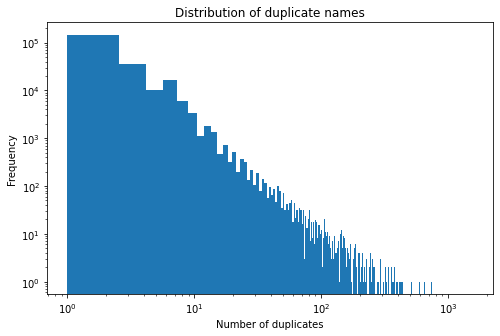

In [5]:
# distibrution de duplicats de noms

(data_bottin['name'].value_counts()
 .plot(kind='hist',loglog=True, bins=1000,
       title='Distribution of duplicate names',
       figsize=(8,5)).set_xlabel('Number of duplicates'));

# Début de clean

In [6]:
#garder seulement les entrées composées d'un mot (et contenu entre paranthèses)

regex_one_word = '^\s*\w+(?:\s?\(.*\)\s*)?\s*$'

predicate_one_word = data_bottin['name'].str.match(regex_one_word) # à remplacer, pour le moment sélélectionne tout

data_bottin_one_word = data_bottin.loc[predicate_one_word].copy()

In [7]:
#nettoyer le numéro de rue: garder seulement le premier nombre et éventuellement 'bis'
data_bottin['number_clean'] = data_bottin['number'].str.extract('(^\d+(?: ?bis)?).*')

# Exploration des données

In [8]:
#extraire le compte de chaque mot entre (), dans name
regex_parens = '^.*?\((.*)\).*?$'

name_parens = data_bottin['name'].str.extract(regex_parens).dropna()[0]

from collections import Counter
name_parens_split = name_parens.str.split('\W')
name_parens_split = name_parens_split.apply(lambda words: [word for word in words if len(word) > 0])

word_counts = Counter()

for words in name_parens_split.values:
    word_counts.update(words)

#afficher les 5 mots les plus communs entre (), dans name    
word_counts.most_common(5)

[('Mme', 44115), ('A', 30836), ('E', 19911), ('J', 19211), ('L', 15187)]

In [9]:
#extraire les mots correspondent pas à predicate_one_word (un seul mot + texte entre paranthèse)
from collections import Counter
name_one_word_split = data_bottin.loc[~predicate_one_word]['name'].str.split('\W')
name_one_word_split = name_one_word_split.apply(lambda words: [word for word in words if len(word) > 0])

word_counts = Counter()

for words in name_one_word_split.values:
    word_counts.update(words)
    
#afficher les 5 expressions les plus communs présents dans les cases name de plus d'un mot      
word_counts.most_common(5)

[('et', 39997), ('Cie', 14393), ('fils', 10686), ('NC', 7170), ('de', 6246)]

In [10]:
#grouper les duplicates et les afficher
(data_bottin
 .groupby(['name', 'job', 'street', 'number'])
 .size()
 .sort_values(ascending=False)
 .value_counts()
 .to_frame('Count')
 .rename_axis('Number of duplicates'))

,Count
Number of duplicates,
1,344036
2,103599
3,48608
4,34341
5,3451
6,1559
7,625
8,272


In [11]:
#meilleurs résultats avec number_clean
(data_bottin
 .groupby(['name', 'street_only', 'number_clean'])
 .size()
 .sort_values(ascending=False)
 .value_counts()
 .to_frame('Count')
 .rename_axis('Number of duplicates'))

,Count
Number of duplicates,
1,252500
2,82877
3,40125
4,29979
5,13214
6,10658
7,6359
8,4221
9,24


Tests pour voir erreurs d'OCR:

In [12]:
(data_bottin
 .groupby(['name', 'job', 'street_only', 'number_clean'])
 .size().to_frame('count')
 .sort_values(ascending=False, by="count")
)

count
name             job                         street_only   number_clean       
Pitt et Scott    agence maritime             Scribe        7                 9
Alquinet         boucher                     d'Italie      31                8
Kohn             fourreur                    Saint-Roch    49                8
Guillut (L.)     coutelier                   Flandre       77                8
Dumas            chaudronnier                Lappe         37                8
...                                                                        ...
Gersant          lôtel St-Nicolas-des-Champs Chapon        56                1
                 hôtel St-Nicolas-des-Champs Chapon        56                1
                 faïences                    Goutte-d'Or   36                1
Gers (P.) et Cie banquiers                   Vivienne      22                1
€ransard         épicerie                    Tombe-Issoire 24                1

[475538 rows x 1 columns]

In [13]:
data_bottin[((data_bottin['name'] == 'Pitt et Scott') | (data_bottin['name'] == 'Pitt et Seott')) & (data_bottin['number_clean'] == '7')]

,directory,page,row,year,name,job,street,number,street_clean,street_only,number_clean
41081,bpt6k9684013b,624,11,1896,Pitt et Scott,agence maritime,r. Scribe,7.,rue Scribe,Scribe,7
87318,bpt6k9684013b,893,115,1896,Pitt et Scott,agence maritime,r. Scribe,7.,rue Scribe,Scribe,7
149400,bpt6k9684454n,703,33,1893,Pitt et Scott,agence maritime,rue Scribe,7.,rue Scribe,Scribe,7
191095,bpt6k9684454n,959,140,1893,Pitt et Scott,agence maritime,rue Seribe,7.,rue Seribe,Seribe,7
215720,bpt6k9685098r,579,85,1898,Pitt et Scott,agents,r. Scribe,7.,rue Scribe,Scribe,7
256820,bpt6k9685098r,821,83,1898,Pitt et Scott,agence maritime,r. Scribe,7.,rue Scribe,Scribe,7
305353,bpt6k9685098r,1104,45,1898,Pitt et Scott,agence maritime,r. Scribe,7. TÉLÉPH. 241. 42.,rue Scribe,Scribe,7
372880,bpt6k9692626p,862,121,1897,Pitt et Seott,agence maritime,r. Scribe,7.,rue Scribe,Scribe,7
419805,bpt6k9692626p,1139,191,1897,Pitt et Scott,agence marilime,r. Scribe,7.,rue Scribe,Scribe,7
483822,bpt6k9732740w,718,166,1894,Pitt et Scott,agence maritime,rue Scribe,7.,rue Scribe,Scribe,7


In [14]:
(data_bottin.loc[~predicate_one_word]
 .groupby(['name', 'job'])
 .size().to_frame('count')
 .sort_values(ascending=False, by="count")
)

,,count
name,job,
Grand-Préau,domicile,11
Saint-Paul,vins,11
Rousseau-Brondex,modes,10
André fils,peintre-vitrier,10
Pitt et Scott,agence maritime,10
...,...,...
Garnier fils NC: et Cie,droguistes,1
Garnier jeune,fabr. de chaises,1
Garnier so,avocat consultant,1


In [15]:
x = data_bottin[['job']].copy().drop_duplicates().reset_index()[['job']]
x.head(len(x))

,job
0,march. de chevaux
1,négociants
2,ingénieur-architecte
3,chaussures
4,ciment
...,...
63790,tresses et ornements pour modes
63791,opticiens-fabricants; usine. r
63792,fabr. de moules pour passementeries
63793,directeur de la Société générale de publicité


In [16]:
y = data_bottin.copy().dropna()
sample = y[y['job'].str.contains("success")]

In [17]:
sample

,directory,page,row,year,name,job,street,number,street_clean,street_only,number_clean
219,bpt6k9684013b,379,181,1896,Adam (G.) (A. Gallais,successeur,sellier Faub. St-Martin,31.,sellierue faubourg Saint-Martin,sellie$1Saint-Martin,31
321,bpt6k9684013b,380,125,1896,Agence Bullier (Portebos,success,r. Vivienne,33.,rue Vivienne,Vivienne,33
1805,bpt6k9684013b,389,163,1896,Antony (Haudebourg aîné,success,enseignes. r. Réaumur,38.,enseignes. rue Réaumur,enseignes.$1Réaumur,38
2116,bpt6k9684013b,391,162,1896,Arnaud-Soumain (M. Vitet,success,brotteur r. St-Augustin,5.,brotteurue rue Saint-Augustin,brotteu$1Saint-Augustin,5
4726,bpt6k9684013b,407,105,1896,*) NC & Marre,success. de,girard,178 bis.,girard,girard,178 bis
...,...,...,...,...,...,...,...,...,...,...,...
827553,bpt6k9764402m,1137,200,1900,Marchand (E.) et ses fils (Monnot,Barthon et Cie success,produits pharmaceutique r. Michel-le-Comte,21.,produits pharmaceutique rue Michel-le-Comte,produits pharmaceutique$1Michel-le-Comte,21
842121,bpt6k9764402m,1225,127,1900,Petit,tuyaux système Petit (Société anonyme des Haut...,r. du Terrage,4.,rue du Terrage,Terrage,4
856620,bpt6k9764402m,1313,167,1900,Schwartz et Cie (Soc. an. de Filatures laine p...,success,fabr. de draps. Poissonnière,35.,fabrue de draps. Poissonnière,fab draps. Poissonnière,35
856835,bpt6k9764402m,1315,56,1900,Séguier literie Darrac (Dufresne NC,success,r. Cadet,24. TÉLÉPH. 148.,rue Cadet,Cadet,24


In [18]:
add_clickable_url(sample.fillna(''))

,directory,page,row,year,name,job,street,number,street_clean,street_only,number_clean,url
219,bpt6k9684013b,379,181,1896,Adam (G.) (A. Gallais,successeur,sellier Faub. St-Martin,31.,sellierue faubourg Saint-Martin,sellie$1Saint-Martin,31,https://gallica.bnf.fr/ark:/12148/bpt6k9684013...
321,bpt6k9684013b,380,125,1896,Agence Bullier (Portebos,success,r. Vivienne,33.,rue Vivienne,Vivienne,33,https://gallica.bnf.fr/ark:/12148/bpt6k9684013...
1805,bpt6k9684013b,389,163,1896,Antony (Haudebourg aîné,success,enseignes. r. Réaumur,38.,enseignes. rue Réaumur,enseignes.$1Réaumur,38,https://gallica.bnf.fr/ark:/12148/bpt6k9684013...
2116,bpt6k9684013b,391,162,1896,Arnaud-Soumain (M. Vitet,success,brotteur r. St-Augustin,5.,brotteurue rue Saint-Augustin,brotteu$1Saint-Augustin,5,https://gallica.bnf.fr/ark:/12148/bpt6k9684013...
4726,bpt6k9684013b,407,105,1896,*) NC & Marre,success. de,girard,178 bis.,girard,girard,178 bis,https://gallica.bnf.fr/ark:/12148/bpt6k9684013...
...,...,...,...,...,...,...,...,...,...,...,...,...
827553,bpt6k9764402m,1137,200,1900,Marchand (E.) et ses fils (Monnot,Barthon et Cie success,produits pharmaceutique r. Michel-le-Comte,21.,produits pharmaceutique rue Michel-le-Comte,produits pharmaceutique$1Michel-le-Comte,21,https://gallica.bnf.fr/ark:/12148/bpt6k9764402...
842121,bpt6k9764402m,1225,127,1900,Petit,tuyaux système Petit (Société anonyme des Haut...,r. du Terrage,4.,rue du Terrage,Terrage,4,https://gallica.bnf.fr/ark:/12148/bpt6k9764402...
856620,bpt6k9764402m,1313,167,1900,Schwartz et Cie (Soc. an. de Filatures laine p...,success,fabr. de draps. Poissonnière,35.,fabrue de draps. Poissonnière,fab draps. Poissonnière,35,https://gallica.bnf.fr/ark:/12148/bpt6k9764402...
856835,bpt6k9764402m,1315,56,1900,Séguier literie Darrac (Dufresne NC,success,r. Cadet,24. TÉLÉPH. 148.,rue Cadet,Cadet,24,https://gallica.bnf.fr/ark:/12148/bpt6k9764402...


que faire avec les entreprises ?
les NC et les abréviations semblables ?
certaines entrées des entrées mal faite

dans job:
successeur): 
success.). 

In [19]:
data_bottin = add_clickable_url(data_bottin.fillna(''))

[year] / Paris. [name], [job], exerce son activité au [number_clean] [street_clean].

In [26]:
#Generate text for wikipast pages
df = pd.DataFrame()

In [27]:
#df['criteria'] = data_bottin['name'].astype(str)+" "\
#+data_bottin['job'].astype(str)+" "\
#+data_bottin['number_clean'].astype(str)+" "\
#+data_bottin['street_clean'].astype(str)

In [86]:
df['page_text'] = "* "+"[["+data_bottin['year'].astype(str)+"]]"\
+" / [[Paris]]. "\
+"[["+data_bottin['name'].astype(str)+"]]"\
+", [["+ data_bottin['job'].astype(str)+"]]"\
+", exerce son activité au "\
+"[["+data_bottin['street_clean'].astype(str)+"]]"\
+" "+data_bottin['number_clean'].astype(str)+"."\
+" ["+data_bottin['url'].astype(str)+"]"

In [87]:
df['name'] = data_bottin['name']
df['job'] = data_bottin['job']
df['street_clean'] = data_bottin['street_clean']
df['number_clean'] = data_bottin['number_clean']

In [88]:
pd.set_option('display.max_colwidth', None)
df.head(1)

,page_text,name,job,street_clean,number_clean
0,"* [[1896]] / [[Paris]]. [[Aaron]], [[march. de chevaux]], exerce son activité au [[rue Bouret]] 39. [https://gallica.bnf.fr/ark:/12148/bpt6k9684013b/f189.item.r=Aaron%20march%20%20de%20chevaux%20r%20%20Bouret%2039.zoom]",Aaron,march. de chevaux,rue Bouret,39


In [89]:
df_grpby = df.groupby(['name','job','street_clean','number_clean'])['page_text'].apply(list)

In [90]:
df1 = df_grpby.to_frame().reset_index()

In [91]:
df1.loc[df1['name']=="Pitt et Scott"]

,name,job,street_clean,number_clean,page_text
396088,Pitt et Scott,agence marilime,rue Scribe,7,"[* [[1897]] / [[Paris]]. [[Pitt et Scott]], [[agence marilime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9692626p/f834.item.r=Pitt%20et%20Scott%20agence%20marilime%20r%20%20Scribe%207%20.zoom]]"
396089,Pitt et Scott,agence maritime,rue Scribe,7,"[* [[1896]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684013b/f435.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom], * [[1896]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684013b/f704.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom], * [[1893]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684454n/f468.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom], * [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f540.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom], * [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f823.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20%20T%C3%89L%C3%89PH%20%20241%20%2042%20.zoom], * [[1894]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9732740w/f479.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom], * [[1890]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k97630871/f323.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom], * [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f384.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom], * [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f637.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]]"
396090,Pitt et Scott,agence maritime,rue Seribe,7,"[* [[1893]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Seribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684454n/f724.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Seribe%207%20.zoom]]"
396091,Pitt et Scott,agents,rue Scribe,5,"[* [[1900]] / [[Paris]]. [[Pitt et Scott]], [[agents]], exerce son activité au [[rue Scribe]] 5. [https://gallica.bnf.fr/ark:/12148/bpt6k9764402m/f347.item.r=Pitt%20et%20Scott%20agents%20r%20%20Scribe%205%20.zoom]]"
396092,Pitt et Scott,agents,rue Scribe,7,"[* [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agents]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f298.item.r=Pitt%20et%20Scott%20agents%20r%20%20Scribe%207%20.zoom]]"


In [92]:
df1['page_text'] = df1['page_text'].apply(lambda l: "\n".join(sorted(l)))

In [93]:
print(df1.iloc[396089]['page_text'])

* [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f384.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]
* [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f637.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]
* [[1890]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k97630871/f323.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]
* [[1893]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684454n/f468.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]
* [[1894]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce s

In [94]:
df1.loc[df1['name']=="Pitt et Scott"]

,name,job,street_clean,number_clean,page_text
396088,Pitt et Scott,agence marilime,rue Scribe,7,"* [[1897]] / [[Paris]]. [[Pitt et Scott]], [[agence marilime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9692626p/f834.item.r=Pitt%20et%20Scott%20agence%20marilime%20r%20%20Scribe%207%20.zoom]"
396089,Pitt et Scott,agence maritime,rue Scribe,7,"* [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f384.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]\n* [[1888]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9763471j/f637.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]\n* [[1890]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k97630871/f323.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]\n* [[1893]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684454n/f468.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]\n* [[1894]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9732740w/f479.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Scribe%207%20.zoom]\n* [[1896]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684013b/f435.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom]\n* [[1896]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684013b/f704.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom]\n* [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f540.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20.zoom]\n* [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f823.item.r=Pitt%20et%20Scott%20agence%20maritime%20r%20%20Scribe%207%20%20T%C3%89L%C3%89PH%20%20241%20%2042%20.zoom]"
396090,Pitt et Scott,agence maritime,rue Seribe,7,"* [[1893]] / [[Paris]]. [[Pitt et Scott]], [[agence maritime]], exerce son activité au [[rue Seribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9684454n/f724.item.r=Pitt%20et%20Scott%20agence%20maritime%20rue%20Seribe%207%20.zoom]"
396091,Pitt et Scott,agents,rue Scribe,5,"* [[1900]] / [[Paris]]. [[Pitt et Scott]], [[agents]], exerce son activité au [[rue Scribe]] 5. [https://gallica.bnf.fr/ark:/12148/bpt6k9764402m/f347.item.r=Pitt%20et%20Scott%20agents%20r%20%20Scribe%205%20.zoom]"
396092,Pitt et Scott,agents,rue Scribe,7,"* [[1898]] / [[Paris]]. [[Pitt et Scott]], [[agents]], exerce son activité au [[rue Scribe]] 7. [https://gallica.bnf.fr/ark:/12148/bpt6k9685098r/f298.item.r=Pitt%20et%20Scott%20agents%20r%20%20Scribe%207%20.zoom]"


In [ ]:
import re
chaine = "*) el Cle"
chaine[re.search("\w", chaine).start(): len(chaine)]


In [ ]:
#drop duplicates entries
df.drop_duplicates(subset ="page_text", 
                     keep = False, inplace = True) 

In [ ]:
if (row['clean_name'] == "0"):
    search = ((y['name'] == row['name']) & (y['criteria'] != row['criteria']))
    current_name = ((y['name'] == row['name']) & (y['criteria'] == row['criteria']))
    clean_name = data_bottin['name'].astype(str)\
    +" ("+ data_bottin['job'].astype(str)+","\
    +" "+data_bottin['street_clean'].astype(str)\
    +" "+data_bottin['number_clean'].astype(str)+")"
        #df.loc[Bool]
    if not (df.loc[search].empty):
        df.loc[search, ['clean_name']] = clean_name
        df.loc[current_name, ['clean_name']] = clean_name
    else:
         row['clean_name'] = row['name']

In [ ]:
df.loc[search]

In [ ]:
y = df.copy()
#data_bottin[((data_bottin['name'] == 'Pitt et Scott') | (data_bottin['name'] == 'Pitt et Seott')) & (data_bottin['number_clean'] == '7')]
#x = y[((y['name'] == 'Aaron') & (y['criteria'] != 'Aaron march. de chevaux 39 rue Bouret'))]
#y[((y['name'] == 'Aaron') & (y['criteria'] != 'Aaron march. de chevaux 39 rue Bouret'))]
for index, row in df.iterrows():
    if (row['clean_name'] == "0"):
        search = ((y['name'] == row['name']) & (y['criteria'] != row['criteria']))
        current_name = ((y['name'] == row['name']) & (y['criteria'] == row['criteria']))
        clean_name = data_bottin['name'].astype(str)\
        +" ("+ data_bottin['job'].astype(str)+","\
        +" "+data_bottin['street_clean'].astype(str)\
        +" "+data_bottin['number_clean'].astype(str)+")"
        #df.loc[Bool]
        if not (df.loc[search].empty):
            df.loc[search, ['clean_name']] = clean_name
            df.loc[current_name, ['clean_name']] = clean_name
        else:
             row['clean_name'] = row['name']         

In [ ]:
df.loc[search]

In [ ]:
user = 'Clement.lhoste@BottinBot6'
password = 'q0fimgpdbef61a9lbkiumrhtpq2prmi8'

In [ ]:
from pywikiapi import Site

In [ ]:
site = Site('http://wikipast.epfl.ch/wikipast/api.php') # Définition de l'adresse de l'API
site.no_ssl = True # Désactivation du https, car pas activé sur wikipast
site.login(user, password) # Login du bot